In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from functools import partial
from pathlib import Path

from tqdm import tqdm
from treeffuser import Treeffuser

path = "../testbed/src/testbed/data/m5/"
# load autoreload extension
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting started

To get started, create a Kaggle account and download the data from https://www.kaggle.com/competitions/m5-forecasting-accuracy/data.

You can also use Kaggle's [command-line tool](https://www.kaggle.com/docs/api) and run the following from the command line:

```bash
cd ./m5 # path to folder where you want to save the data
kaggle competitions download -c m5-forecasting-accuracy
```

Use your favorite tool to unzip the archive. In Linux/macOS,

```bash
unzip m5-forecasting-accuracy.zip
```

We'll be using the following files: `calendar.csv`, `sales_train_validation.csv`, and `sell_prices.csv`.


<!-- - `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date. -->
<!-- - `sales_train_evaluation.csv`- Includes sales [`d_1 - d_1941]` (labels used for the Public leaderboard). -->
<!-- - `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info. -->

In [60]:
# import data
data_path = "./m5"  # change with path where you extracted the data archive

calendar_df = pd.read_csv(Path(data_path) / "calendar.csv")
sales_train_df = pd.read_csv(Path(data_path) / "sales_train_validation.csv")
sell_prices_df = pd.read_csv(Path(data_path) / "sell_prices.csv")

# add explicit columns for the day, month, year for ease of processing
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df["day"] = calendar_df["date"].dt.day
calendar_df["month"] = calendar_df["date"].dt.month
calendar_df["year"] = calendar_df["date"].dt.year

# The data
`sell_prices_df` contains the prices of each item in each store at a given time. The `wm_yr_wk` is a unique identifier for the time.

In [61]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


`calendar_df` contains information about the dates on which the products were sold.

In [62]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,2


`sales_train_df` contains the number of units sold for an item in each department and store. The sales are grouped by day: for example, the `d_1907` column has the number of units sold on the 1907-th day.

In [63]:
sales_train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


To align the sales data with the other DataFrames, we convert `sales_train_df` to a long format. We collapse the daily sales columns `d_{i}` into a single `sales` column, with an  additional `day` column indicating the day corresponding to each sales entry.

In [64]:
def convert_sales_data_from_wide_to_long(sales_df_wide):
    index_vars = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
    sales_df_long = pd.wide_to_long(
        sales_df_wide.iloc[:100, 1:],
        i=index_vars,
        j="day",
        stubnames=["d"],
        sep="_",
    ).reset_index()

    sales_df_long = sales_df_long.rename(columns={"d": "sales", "day": "d"})

    sales_df_long["d"] = "d_" + sales_df_long["d"].astype(
        "str"
    )  # restore "d_{i}" format for day
    return sales_df_long


sales_train_df_long = convert_sales_data_from_wide_to_long(sales_train_df)
sales_train_df_long.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0


Text(0.5, 1.0, 'number of sales over the entire timespan')

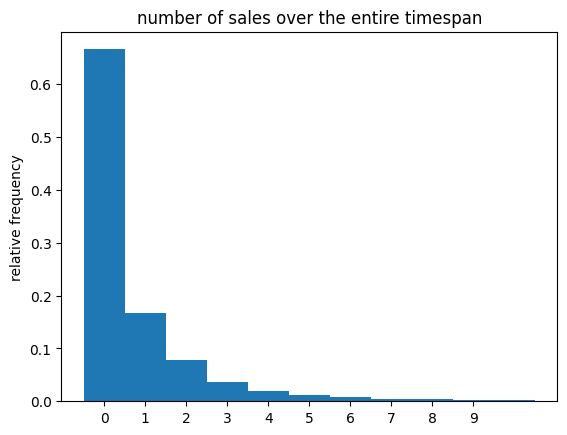

In [65]:
plt.hist(
    sales_train_df_long["sales"],
    bins=np.arange(0, 10 + 1.5) - 0.5,
    range=[0, 10],
    density=True,
)
plt.xticks(range(10))
plt.ylabel("relative frequency")
plt.title("number of sales over the entire timespan")

### Train and test data

The dataset comprises sales data of 100 items over 1,913 days. For simplicity, we select the data from the first 365 days and discard the rest.

In [66]:
print(f"n_items = {len(sales_train_df_long['item_id'].unique())}")
print(f"n_days = {len(sales_train_df_long['d'].unique())}")

sales_train_df_long["day_number"] = sales_train_df_long["d"].str.extract("(\d+)").astype(int)
data = sales_train_df_long[sales_train_df_long["day_number"] <= 365].copy()

n_items = 100
n_days = 1913


We compute the lags of the previous 30 days and merge the sales, calendar, and price data together.

In [67]:
n_lags = 30

# sort data before computing lags
data_index_vars = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
data.sort_values(data_index_vars + ["day_number"], inplace=True)

for lag in range(1, n_lags + 1):
    data[f"sales_lag_{lag}"] = data.groupby(by=data_index_vars)["sales"].shift(lag)

data = data.merge(calendar_df).merge(sell_prices_df)

data.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,sales_lag_1,sales_lag_2,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day,sell_price
0,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_141,0,141,0.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,18,3.97
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_142,0,142,0.0,0.0,...,2011,Father's day,Cultural,NaN,NaN,0,0,0,19,3.97
2,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_143,0,143,0.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,20,3.97
3,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_144,1,144,0.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,21,3.97
4,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_145,0,145,1.0,0.0,...,2011,NaN,NaN,NaN,NaN,0,0,0,22,3.97


Finally, for each item, we take the first 300 days as train data and use the remaining 65 data as test data for posterior predictive checks.

In [68]:
is_train = data["day_number"] <= 300
data = data.drop(columns=["day_number", "day"])

y_name = "sales"
x_names = [name for name in data.columns if name != y_name]

X_train, y_train = data[is_train][x_names], data[is_train][y_name]
X_test, y_test = data[~is_train][x_names], data[~is_train][y_name]

print(X_train.shape)
print(X_test.shape)

(15216, 50)
(3891, 50)


The features of the combined datasets are mostly categorical. We save the column indices in `cat_idx` as they will come in handy later.

In [69]:
cat_column_names = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "d",
    "date",
    "wm_yr_wk",
    "weekday",
    "wday",
    "month",
    "year",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
]
cat_idx = [data.columns.get_loc(col) for col in cat_column_names]
cat_idx

[0, 1, 2, 3, 4, 5, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

# Probabilistic predictions with Treeffuser

We regress the sales on the following covariates.

In [70]:
print(", ".join(map(str, X_train.columns)))

item_id, dept_id, cat_id, store_id, state_id, d, sales_lag_1, sales_lag_2, sales_lag_3, sales_lag_4, sales_lag_5, sales_lag_6, sales_lag_7, sales_lag_8, sales_lag_9, sales_lag_10, sales_lag_11, sales_lag_12, sales_lag_13, sales_lag_14, sales_lag_15, sales_lag_16, sales_lag_17, sales_lag_18, sales_lag_19, sales_lag_20, sales_lag_21, sales_lag_22, sales_lag_23, sales_lag_24, sales_lag_25, sales_lag_26, sales_lag_27, sales_lag_28, sales_lag_29, sales_lag_30, date, wm_yr_wk, weekday, wday, month, year, event_name_1, event_type_1, event_name_2, event_type_2, snap_CA, snap_TX, snap_WI, sell_price


Currently, Treeffuser supports only numpy.ndarray data with numerical values. Therefore, we convert the categorical columns into numerical labels and then convert the train and test data into numpy.ndarray.

In [71]:
X_train[cat_column_names] = X_train[cat_column_names].apply(
    lambda col: pd.Categorical(col).codes
)

X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

We are now ready to fit the data. We use `cat_idx` to tell Treeffuser which columns are categorical.

In [72]:
model = Treeffuser()
model.fit(X_train, y_train, cat_idx=cat_idx)

/Users/agrande/Desktop/treeffuser/src/treeffuser/_base_tabular_diffusion.py:114: CastFloat32Warning: Input array is not float; it has been recast to float32.
  y = _check_array(y)


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


Treeffuser(extra_lightgbm_params={})

# Process the data

For simplicity, we randomly select 10 items. This is controlled by `TOTAL_ITEMS`.

columns_sales_train_validation.head)

The strategy for processing the data is going to be the following. 1) We are going to have X and y where y is the next days sales for a given product. 3) X is made up of 10 previous prices, day of the week, + event types, cat_id, store_id, state_id

In [ ]:
def proc_train_test(
    sales_train_validation_df: pd.DataFrame,
    calendar_df: pd.DataFrame,
    sell_prices_df: pd.DataFrame,
    context_length: int,
    test_days,
):  # type annotation too long
    """
    This function processes the data and returns the training and test data in two ways:
    - undifferentiated: a list of all training and test data (X_train, y_train, X_test, y_test)
    - differentiated: a list of training and test data for each product (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
        where X_train_prod[i] contains a list of all X_train values for the product i with similar grouping for y_train_prod and test

    This assumes from the dataframes that
    - sales_train_validation_df:
        - has columns with the format d_1, d_2, ...
        - has columns item_id and store_id
    - calendar_df:
        - wday, month, event_name_1, event_name_2
    - sell_prices_df:
        - item_id, store_id, sell_price

    - percentage_omitted: percentage of the data to be omitted from the training data and the test data
        (randomly selected)

    Returns:
    - undifferentiated: Tuple of X_train, y_train, X_test, y_test
    - differentiated: Tuple of X_train_prod, y_train_prod, X_test_prod, y_test_prod
    """
    np.random.seed(0)
    # First we need to get the training data
    # We will use the first 1913 days as training data and the next

    X_train = []
    y_train = []

    X_test = []
    y_test = []

    # We will also return a second grouping of lists where X_train_prod[i] contains a
    # a list of all X_train values for the product i with similar grouping for y_train_prod and test
    X_train_prod = []
    y_train_prod = []
    X_test_prod = []
    y_test_prod = []

    # get all days that start with d_ and look for the maximum
    total_days = max(
        [int(x.split("_")[1]) for x in sales_train_validation_df.columns if "d_" in x]
    )
    train_days = total_days - test_days
    print("train days", train_days)
    print("test days", total_days - train_days)
    print("total days", total_days)

    # Precompute the required data
    calendar_df_dict = calendar_df.set_index("d").to_dict(orient="index")
    sell_prices_dict = (
        sell_prices_df.groupby(["item_id", "store_id"])["sell_price"].first().to_dict()
    )

    pbar = tqdm(total=len(sales_train_validation_df))
    for _, row in sales_train_validation_df.iterrows():
        item_id = row["item_id"]
        store_id = row["store_id"]

        X_train_prod.append([])
        y_train_prod.append([])
        X_test_prod.append([])
        y_test_prod.append([])

        pbar.update(1)

        valid_size = int((train_days - context_length)
        valid_js = np.random.choice(
            range(1, train_days - context_length), valid_size, replace=False
        )

        valid_js = list(valid_js) + list(
            range(train_days - context_length, total_days - context_length)
        )

        for j in valid_js:
            x = []

            # Add sales values for the previous context_length days
            x.extend(row[f"d_{j+k}"] for k in range(context_length))

            # Add additional features
            current_day = f"d_{j+context_length}"
            calendar_data = calendar_df_dict[current_day]
            x.extend(
                [
                    calendar_data["wday"],
                    calendar_data["month"],
                    store_id,
                    calendar_data["event_name_1"],
                    calendar_data["event_name_2"],
                    sell_prices_dict[(item_id, store_id)],
                    item_id,
                    j + context_length,
                ]
            )

            if j < train_days:
                X_train.append(x)
                y_train.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

            else:
                X_test.append(x)
                y_test.append(row[current_day])
                X_train_prod[-1].append(x)
                y_train_prod[-1].append(row[current_day])

    undifferentiated = (X_train, y_train, X_test, y_test)
    differentiated = (X_train_prod, y_train_prod, X_test_prod, y_test_prod)
    return undifferentiated, differentiated

In [ ]:
if PROCESS_FROM_SCRATCH:
    undifferentiated, differentiated = proc_train_test(
        sales_train_validation_df_sub,
        calendar_df,
        sell_prices_df_sub,
        CONTEXT_LENGTH,
        30,
        0.99,
    )
    X_train, y_train, X_test, y_test = undifferentiated
    X_train_prod, y_train_prod, X_test_prod, y_test_prod = differentiated

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
COL_NAMES = [f"day_{i}" for i in range(1, CONTEXT_LENGTH + 1)] + [
    "wday",
    "month",
    "store_id",
    "event_name_1",
    "event_name_2",
    "sell_price",
    "item_id",
    "day",
]

CAT_COLS = ["store_id", "event_name_1", "event_name_2", "item_id", "wday", "month"]
CAT_COLS_IDX = [COL_NAMES.index(col) for col in CAT_COLS]

In [ ]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

X_train_df.columns = COL_NAMES
X_test_df.columns = COL_NAMES

In [ ]:
X_train_df

In [ ]:
# Encode the categorical columns as numbers
from sklearn.preprocessing import LabelEncoder

# Get only label of item_id
X_train_df["item_id"] = X_train_df["item_id"].apply(lambda x: x.split("_")[1])
X_test_df["item_id"] = X_test_df["item_id"].apply(lambda x: x.split("_")[1])


label_encoders = {}
for col in CAT_COLS:
    le = LabelEncoder()
    X_train_df[col] = le.fit_transform(X_train_df[col])
    X_test_df[col] = le.transform(X_test_df[col])
    label_encoders[col] = le


X_train_prod_processed = []
X_test_prod_processed = []
for i in range(len(X_train_prod)):
    X_train_prod_processed.append(pd.DataFrame(X_train_prod[i], columns=COL_NAMES))
    X_test_prod_processed.append(pd.DataFrame(X_test_prod[i], columns=COL_NAMES))
    X_train_prod_processed[-1]["item_id"] = X_train_prod_processed[-1]["item_id"].apply(
        lambda x: x.split("_")[1]
    )
    X_test_prod_processed[-1]["item_id"] = X_test_prod_processed[-1]["item_id"].apply(
        lambda x: x.split("_")[1]
    )
    for col in CAT_COLS:
        X_train_prod_processed[-1][col] = label_encoders[col].transform(
            X_train_prod_processed[-1][col]
        )
        X_test_prod_processed[-1][col] = label_encoders[col].transform(
            X_test_prod_processed[-1][col]
        )

X_train_df.head()

# PPC

### "Standard PPCs"

In [ ]:
def max_ppc(
    y_true: Float[Array, "batch y_dim"],
    y_samples: Float[Array, "samples batch y_dim"],
    number=0,
    name="",
) -> None:
    # rpeat y_true to match the shape of y_samples
    max_ppc = np.max(y_samples, axis=1)
    true_max = np.max(y_true)

    return max_ppc.flatten(), true_max.flatten(), "max_ppc"


def quantile_ppc(
    y_true: Float[Array, "batch y_dim"],
    y_samples: Float[Array, "samples batch y_dim"],
    quantile=0.5,
    number=0,
    name="",
) -> None:
    # rpeat y_true to match the shape of y_samples
    q = np.quantile(y_samples, quantile, axis=1)
    true_q = np.quantile(y_true, quantile)
    return q.flatten(), true_q.flatten(), f"quantile_ppc_{quantile}"


def zeros(
    y_true: Float[Array, "batch y_dim"],
    y_samples: Float[Array, "samples batch y_dim"],
    number=0,
    name="",
) -> None:
    "Count the number of zeros in the samples"
    zeros = np.sum(y_samples < 0.1, axis=1)
    true_zeros = np.sum(y_true < 0.1)

    return zeros.flatten(), true_zeros.flatten(), "zeros"

In [ ]:
def plot_ppcs(
    y_true: Float[Array, "batch y_dim"],
    y_samples: Float[Array, "samples batch y_dim"],
    ppcs: List[Callable],
    number=0,
    name="",
) -> None:
    # plot the distribution of

    for ppc in ppcs:
        ppc(y_true, y_samples, number=number, name=name)

### "Complex PPCs"

In [ ]:
def plot_model_comparisons(data, y_true, figsize=(12, 8), model_names=None):
    """
    Plots model predictions against true values for each day.

    :param data: numpy array of shape [models, samples, days] containing model predictions
    :param y_true: array of shape [days] containing the true values
    :param figsize: tuple indicating the size of the figure
    """
    sns.set(style="whitegrid")
    models, samples, days = data.shape

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=figsize)

    # We will transform the data to a format suitable for seaborn
    # Create a DataFrame with model, day, and sample values
    plot_data = []
    if model_names is None:
        model_names = [f"Model {i}" for i in range(models)]

    for model_idx in range(models):
        for day_idx in range(days):
            for sample_idx in range(samples):
                plot_data.append(
                    {
                        "Day": day_idx,
                        "Value": data[model_idx, sample_idx, day_idx],
                        "Model": model_names[model_idx],
                    }
                )

    import pandas as pd

    plot_data = pd.DataFrame(plot_data)

    # Use seaborn to plot the boxplots
    sns.boxplot(x="Day", y="Value", hue="Model", data=plot_data, ax=ax, width=0.6)

    # Plot true values
    plt.plot(y_true, "o", color="red", label="True Values")

    # Setting labels and title
    plt.xticks(ticks=np.arange(days), labels=[f"Day {i+1}" for i in range(days)])
    plt.xlabel("Days")
    plt.ylabel("Values")
    plt.title("Model Predictions vs. True Values")
    plt.legend()

    # Show the plot
    plt.show()

# Model Evaluation

In [ ]:
def save_results_to_pkl(results: dict, dir_name, name):
    if not Path(dir_name).exists():
        Path(dir_name).mkdir(parents=True)

    path = Path(dir_name) / f"{name}.pkl"
    with open(path, "wb") as f:
        pkl.dump(results, f)


def load_results_from_pkl(dir_name, name):
    path = Path(dir_name) / f"{name}.pkl"
    with open(path, "rb") as f:
        results = pkl.load(f)
    return results

In [ ]:
# Simple helper function to train a model and plot ppcs


def get_ppcs(y_samples, X_test, y_test, ppcs, number=0, name="") -> None:
    """
    Returns a dictionary with the samples and the true values for each ppc
    the dictionary a
    """
    y_samples = np.array(y_samples)
    y_samples = np.maximum(y_samples, 0)
    y_samples = np.round(y_samples, 0)

    ppc_results = {}
    for ppc in ppcs:
        samples, true, name = ppc(y_test, y_samples, number=number, name=name)
        ppc_results[name] = {"samples": samples, "true": true}

    return ppc_results

In [ ]:
print(X_train_df.head())